In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import cwt, icwt, ssq_cwt, ssq_stft, issq_cwt, ssqueeze

In [2]:
from scipy import signal
import obspy
import datetime

In [3]:
from scipy import fft, ifft

In [5]:
def slice_waveforms(st, starttime, endtime):
    '''plot sliced waveform
    starttime and endtime in UTCDateTime format'''
    # convert the format of the data
    st_cut = st.slice(starttime,endtime)
    delta_t = st.stats.delta
    #print(st_cut.stats)
    waveform_data = st_cut.data
    waveform_time = np.arange(st_cut.stats.npts)*delta_t
    #%matplotlib inline
    #plt.plot(waveform_time, waveform_data)
    #plt.show()
    
    return st_cut, waveform_data, waveform_time

In [244]:
%matplotlib inline

         network: IU
         station: XMAS
        location: 00
         channel: BH1
       starttime: 2017-12-31T23:59:59.994538Z
         endtime: 2018-01-01T23:59:59.994538Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 3456001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 61715, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 31598080})


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

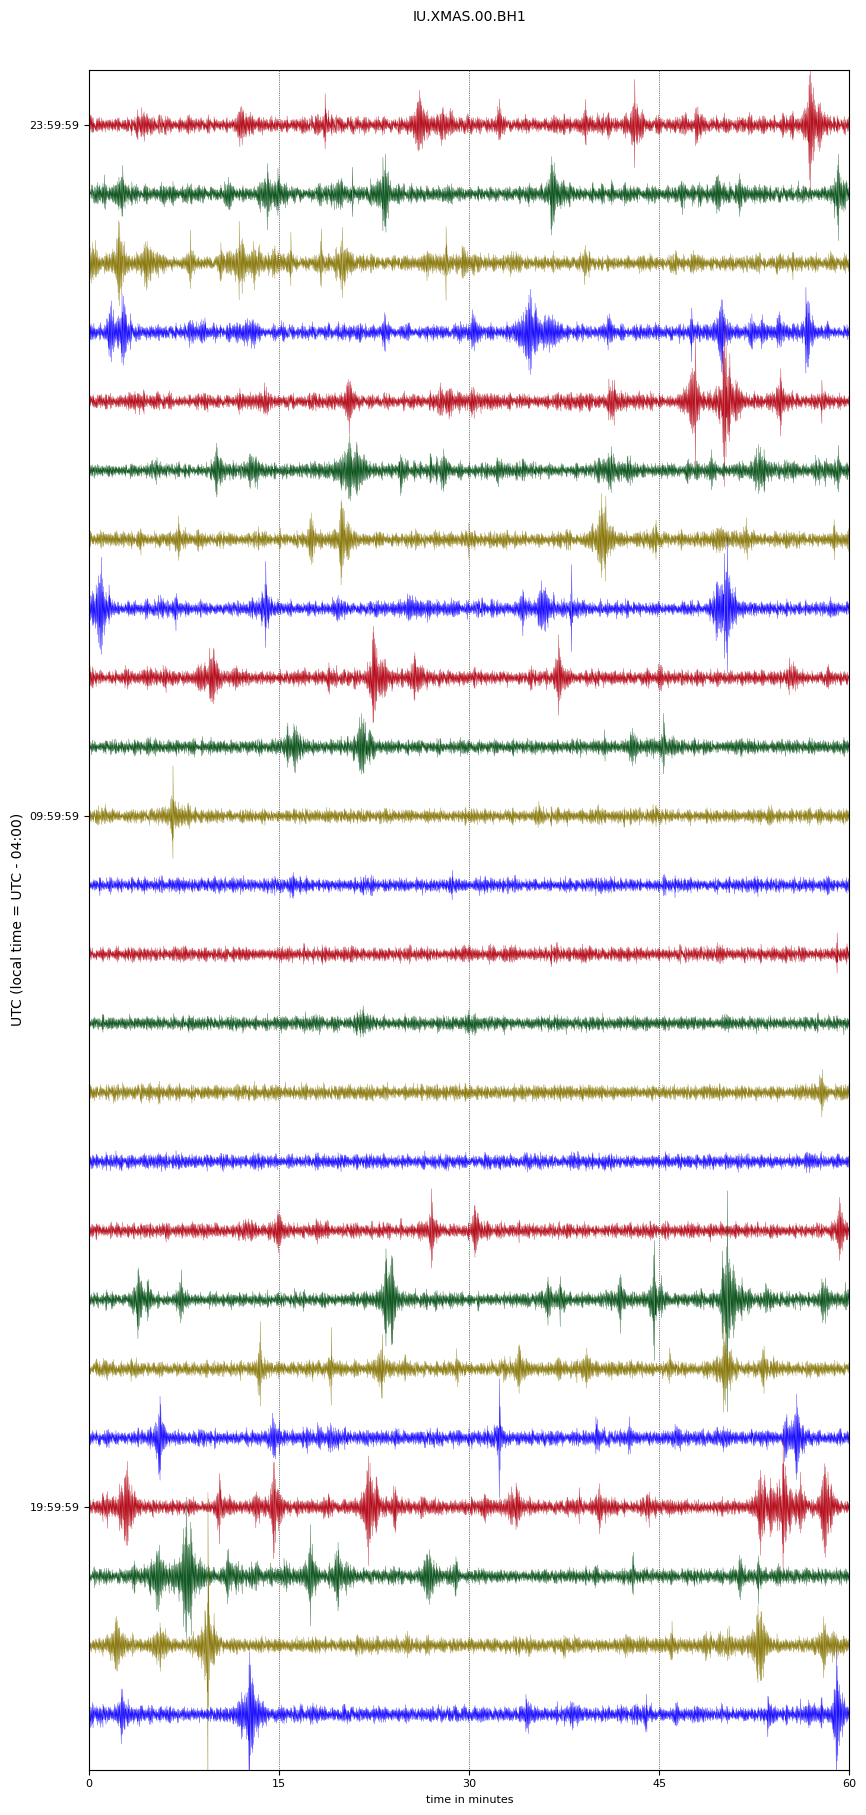

In [204]:
working_dir = '/Users/Yin9xun/Work/island_stations/waveforms'
st = obspy.read(working_dir + '/*XMAS*BH1*.mseed')
print(st[0].stats)
#st = st.filter('highpass', freq=8, corners=2, zerophase=True)
st.plot(type='dayplot',interval=60, size=(1000,2000), linewidth=0.25)

Get the noise window and use its maximum ssq_cwt coefficient as the soft threshold for noise removal

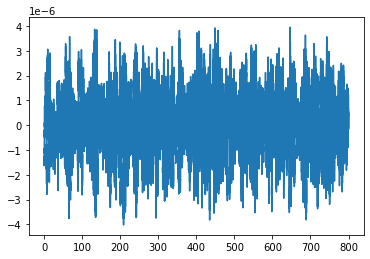

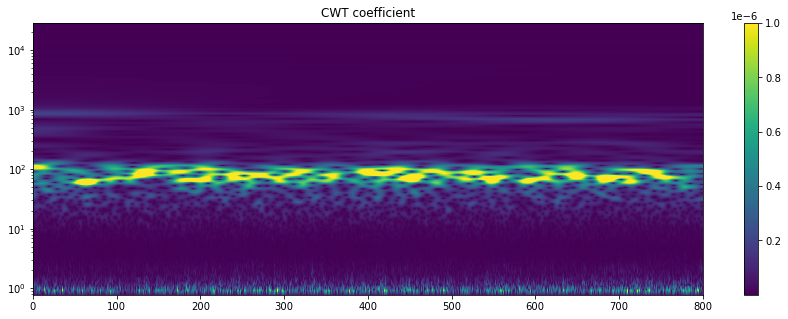

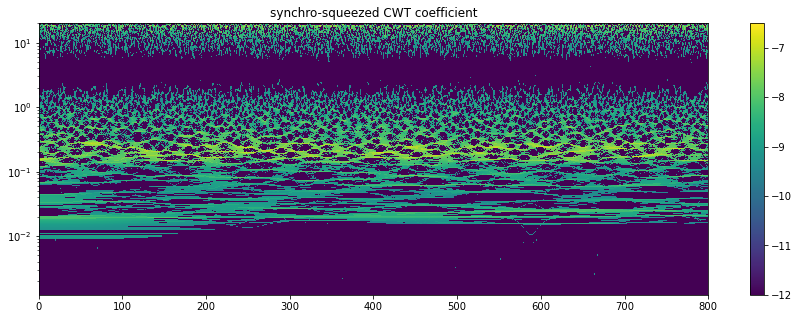

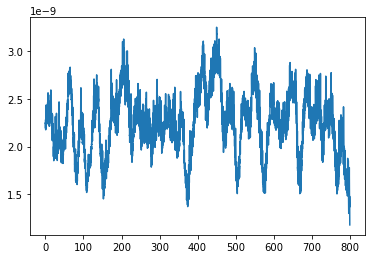

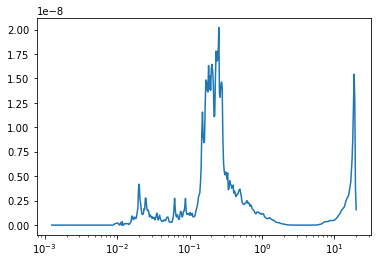

In [247]:
# find the noise window
starttime = st[0].stats.starttime + 12 * 3600
endtime = starttime + 800
st_cut, waveform_data, waveform_time = slice_waveforms(st[0], starttime, endtime)
plt.plot(waveform_time, waveform_data)
# synchro-squeezed CWT for the noise
fs = st_cut.stats.sampling_rate
Twxo, Wxo, ssq_freqs,scale, *_ = ssq_cwt(waveform_data, fs=fs, t=waveform_time)

# visualize the noise cwt
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, scale, abs(Wxo),shading='auto', vmax=1e-6)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

# visualize the noise ssq coefs
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, ssq_freqs, np.log10(abs(Twxo)+1e-12),shading='auto', vmax=-6.5)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('synchro-squeezed CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

plt.figure()
DF_noise = np.mean(np.abs(Twxo), axis=0)
plt.plot(waveform_time, DF_noise)
plt.show()

plt.figure()
CF_noise = np.mean(np.abs(Twxo), axis=1)
plt.semilogx(ssq_freqs, CF_noise)
plt.show()

In [249]:
f_seg = 3

Twxo_LF = Twxo[ssq_freqs<f_seg,:]
Twxo_HF = Twxo[ssq_freqs>=f_seg,:]

gammaN_LF = np.sqrt(2*np.log(len(waveform_time))) * np.mean(np.abs(np.abs(Twxo_LF) - np.mean(np.abs(Twxo_LF)))) * 1.4826
Mmax_LF = np.mean(np.max(abs(Twxo_LF), axis=1))

gammaN_HF = np.sqrt(2*np.log(len(waveform_time))) * np.mean(np.abs(np.abs(Twxo_HF) - np.mean(np.abs(Twxo_HF)))) * 1.4826
Mmax_HF = np.mean(np.max(abs(Twxo_HF), axis=1))


scale_seg = 3
Wxo_LF = Wxo[scale.flatten()>scale_seg,:]
gamma_CWT_LF = np.sqrt(2*np.log(len(waveform_time))) * np.mean(np.abs(np.abs(Wxo_LF) - np.mean(np.abs(Wxo_LF)))) * 1.4826

In [250]:
print(f_seg)
print(gammaN_HF)
print(Mmax_HF)


print(gammaN_LF)
print(Mmax_LF)

3
1.42741407595e-08
2.69920430507e-08
2.3871017331e-08
2.41546817299e-08


In [251]:
print(gamma_CWT_LF)

8.36284759287e-07


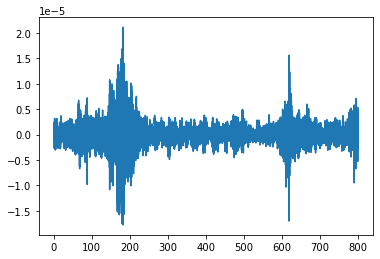

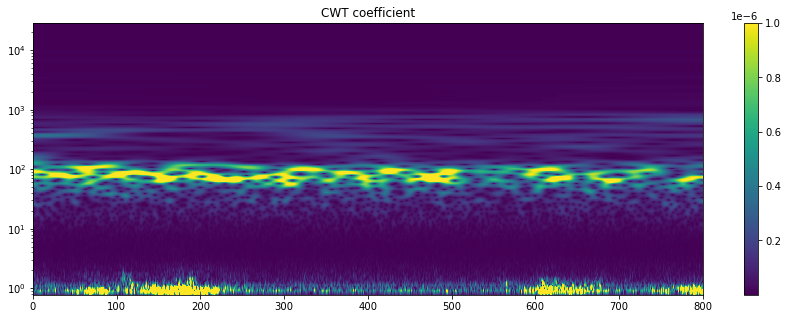

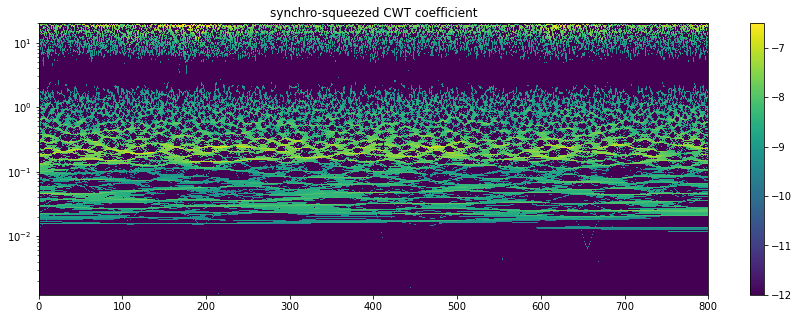

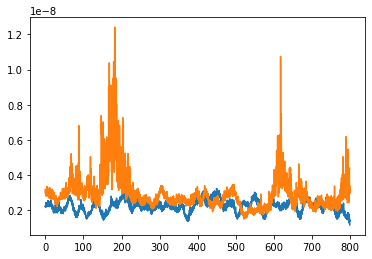

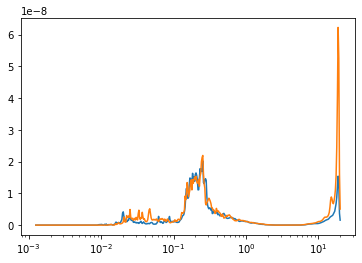

In [290]:
# check the signal window
starttime = st[0].stats.starttime + 20 * 3600
endtime = starttime + 800
st_cut, waveform_data, waveform_time = slice_waveforms(st[0], starttime, endtime)
plt.plot(waveform_time, waveform_data)
# synchro-squeezed CWT for the noise
fs = st_cut.stats.sampling_rate
Twxo, Wxo, ssq_freqs,scale, W, dWx = ssq_cwt(waveform_data, fs=fs, t=waveform_time)

# visualize the noise cwt
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, scale, abs(Wxo),shading='auto', vmax=1e-6)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

# visualize the noise ssq coefs
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, ssq_freqs, np.log10(abs(Twxo)+1e-12),shading='auto', vmax=-6.5)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('synchro-squeezed CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

plt.figure()
DF_signal = np.mean(np.abs(Twxo), axis=0)
plt.plot(waveform_time, DF_noise)
plt.plot(waveform_time, DF_signal)
plt.show()

plt.figure()
CF_signal = np.mean(np.abs(Twxo), axis=1)
plt.semilogx(ssq_freqs, CF_noise)
plt.semilogx(ssq_freqs, CF_signal)
plt.show()

# Deal with the CWT in different frequency band first

low frequency CWT is soft-thresholded

In [253]:
Wxo_threshold = Wxo.copy()
Wxo_threshold[scale.flatten()>scale_seg,:] = soft_threshold(Wxo_threshold[scale.flatten()>scale_seg,:], gamma_CWT_LF)

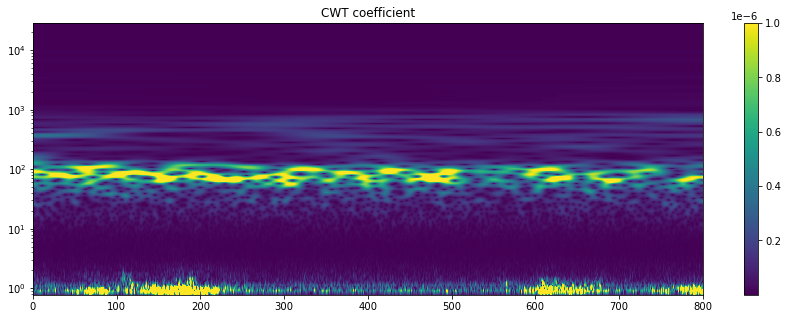

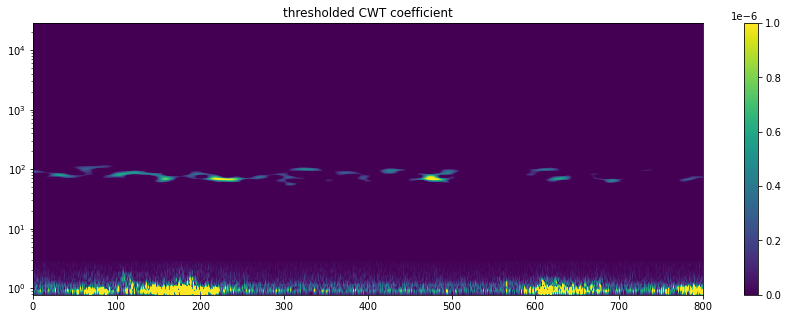

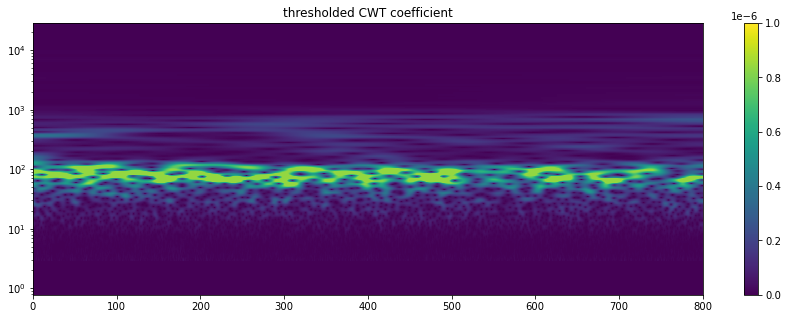

In [254]:
# visualize the noise ssq coefs
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, scale, abs(Wxo),shading='auto', vmax=1e-6)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, scale, abs(Wxo_threshold),shading='auto', vmax=1e-6)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('thresholded CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, scale, abs(Wxo)-abs(Wxo_threshold),shading='auto', vmax=1e-6)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('thresholded CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

In [259]:
Wxo_threshold.shape

(392, 32001)

In [260]:
W.shape

(392, 32001)

In [261]:
ssq_freqs.shape

(392,)

In [265]:
scale.flatten().shape

(392,)

In [276]:
ssqueeze?

In [289]:
ssq_cwt?

In [288]:
w = imag(wev.dWx ./ wev.wl / (2*pi));

array([[  7.87990423e-01,   8.05245166e-01,   8.22877739e-01,
          8.40896415e-01,   8.59309649e-01,   8.78126080e-01,
          8.97354538e-01,   9.17004043e-01,   9.37083817e-01,
          9.57603281e-01,   9.78572062e-01,   1.00000000e+00,
          1.02189715e+00,   1.04427378e+00,   1.06714040e+00,
          1.09050773e+00,   1.11438674e+00,   1.13878863e+00,
          1.16372486e+00,   1.18920712e+00,   1.21524736e+00,
          1.24185781e+00,   1.26905096e+00,   1.29683955e+00,
          1.32523664e+00,   1.35425555e+00,   1.38390988e+00,
          1.41421356e+00,   1.44518081e+00,   1.47682615e+00,
          1.50916443e+00,   1.54221083e+00,   1.57598085e+00,
          1.61049033e+00,   1.64575548e+00,   1.68179283e+00,
          1.71861930e+00,   1.75625216e+00,   1.79470908e+00,
          1.83400809e+00,   1.87416763e+00,   1.91520656e+00,
          1.95714412e+00,   2.00000000e+00,   2.04379430e+00,
          2.08854756e+00,   2.13428080e+00,   2.18101547e+00,
        

In [287]:
Twxo_threshold = ssqueeze(Wxo_threshold, W, scales=scale.T)

/Users/Yin9xun/opt/anaconda3/envs/spyder-py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Yin9xun/opt/anaconda3/envs/spyder-py36/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: attempt to get argmax of an empty sequence

Calculate the threshold from the noise segment

Save the noise window

In [115]:
file_name = st_cut.stats.network + '.' + st_cut.stats.station + '.' + st_cut.stats.channel + '.' + 'noise_window.mseed'
print(file_name)
st_cut.write(working_dir + '/denoise/' + file_name, format="MSEED")  

IU.KIP.BH1.noise_window.mseed


# TODO: separate low and high frequency and use different thresholding (mentioned in the paper by Moussavi et al., 2016)

Use soft threshold to remove the noise, loop per hour data

In [178]:
# soft thresholding
def soft_threshold(y, gamma):
    II1 = np.abs(y) > gamma
    II2 = np.abs(y) <= gamma
    x = y.copy()
    x[II1] = x[II1] * (np.abs(x[II1]) - gamma) / np.abs(x[II1])
    x[II2] = 0
    return x

# hard thresholding
def hard_threshold(y, gamma):
    x = y.copy()
    x[np.abs(x)<gamma] = 0
    return x

In [179]:
# scale the coef to denoise
def scale_to_denoise(Twxo, gammaN, Mmax):
    II1 = np.abs(Twxo) > Mmax
    II2 = (np.abs(Twxo) > gammaN) & (np.abs(Twxo) <= Mmax)
    II3 = np.abs(Twxo) < gammaN
    
    Twxo_processed = Twxo.copy()
    #Twxo_processed[II1] = Twxo[II1] * (np.abs(Twxo[II1]) - Mmax) / np.abs(Twxo[II1])
    Twxo_processed[II1] = Twxo[II1]
    Twxo_processed[II2] = Twxo[II2] * (np.abs(Twxo[II2]) - gammaN) / np.abs(Twxo[II2])
    Twxo_processed[II3] = 0
    
    return Twxo_processed

In [214]:
#Twxo_processed = scale_to_denoise(Twxo, gammaN, Mmax)
Twxo_processed = Twxo.copy()

In [215]:
#Twxo_processed[ssq_freqs>f_seg,:] = hard_threshold(Twxo_processed[ssq_freqs>f_seg,:], gammaN_HF)
#Twxo_processed[ssq_freqs>f_seg,:] = soft_threshold(Twxo_processed[ssq_freqs>f_seg,:], gammaN_HF)
Twxo_processed[ssq_freqs>f_seg,:] = scale_to_denoise(Twxo_processed[ssq_freqs>f_seg,:], gammaN_HF, Mmax_HF)

In [216]:
Twxo_processed[ssq_freqs<=f_seg,:] = soft_threshold(Twxo_processed[ssq_freqs<=f_seg,:], Mmax_LF)
#Twxo_processed[ssq_freqs<=f_seg,:] = hard_threshold(Twxo_processed[ssq_freqs<=f_seg,:], Mmax_LF)
#Twxo_processed[ssq_freqs<=f_seg,:] = 0
#Twxo_processed[ssq_freqs<=f_seg,:] = scale_to_denoise(Twxo_processed[ssq_freqs<=f_seg,:], gammaN_LF, Mmax_LF)

In [213]:
# visualize the noise ssq coefs
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, ssq_freqs, np.log10(abs(Twxo)+1e-12),shading='auto', vmax=-6.5)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('synchro-squeezed CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, ssq_freqs, np.log10(abs(Twxo_processed)+1e-12),shading='auto', vmax=-6.5)#shading='gouraud')
plt.colorbar(sb)
plt.yscale('log')
plt.title('synchro-squeezed CWT coefficient')
#plt.ylim(fs/4, fs/2)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [217]:
%matplotlib widget
waveform_issq_threshold = issq_cwt(Twxo_processed)
plt.figure(figsize=(10,5))
plt.plot(waveform_data)
plt.plot(waveform_issq_threshold,alpha=0.8)
#plt.xlim(7600,7750)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [175]:
# loop over hour to denoise the seismograms

for i_hour in np.arange(1):
    starttime = st[0].stats.starttime + i_hour * 3600
    endtime = starttime + 3600
    st_cut, waveform_data, waveform_time = slice_waveforms(st[0], starttime, endtime)

    print(starttime)
    fs = st_cut.stats.sampling_rate
    Twxo, Wxo, ssq_freqs,scale, *_ = ssq_cwt(waveform_data, fs=fs, t=waveform_time)

    # soft thresholding to do the noise removal
    Twxo_threshold = soft_threshold(Twxo, gamma)

    # inverse synchro-squeezed CWT to reconstruct the waveform
    waveform_issq_threshold = issq_cwt(Twxo_threshold)
    
    st_cut.data = waveform_issq_threshold
    if i_hour == 0:
        st_denoise = st_cut.copy()
    else:
        st_denoise += st_cut


2017-12-31T23:59:59.994538Z


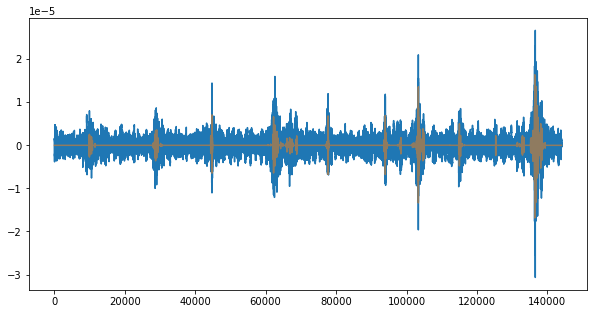

In [176]:
plt.figure(figsize=(10,5))
plt.plot(waveform_data)
plt.plot(st_denoise.data,alpha=0.5)
#plt.xlim(13700,14200)

In [162]:
st_denoise.data=st_denoise.data.filled(fill_value=0)

AttributeError: 'numpy.ndarray' object has no attribute 'filled'

In [65]:
file_name = st_denoise.stats.network + '.' + st_denoise.stats.station + '.' + st_denoise.stats.channel + '.' + 'denoised.mseed'
print(file_name)

IU.XMAS.BH1.denoised.mseed


In [67]:
print(working_dir + '/denoise/' + file_name)

/Users/Yin9xun/Work/island_stations/waveforms/IU.XMAS.BH1.denoised.mseed


In [66]:
st_denoise.write(working_dir + '/denoise/' + file_name, format="MSEED")  

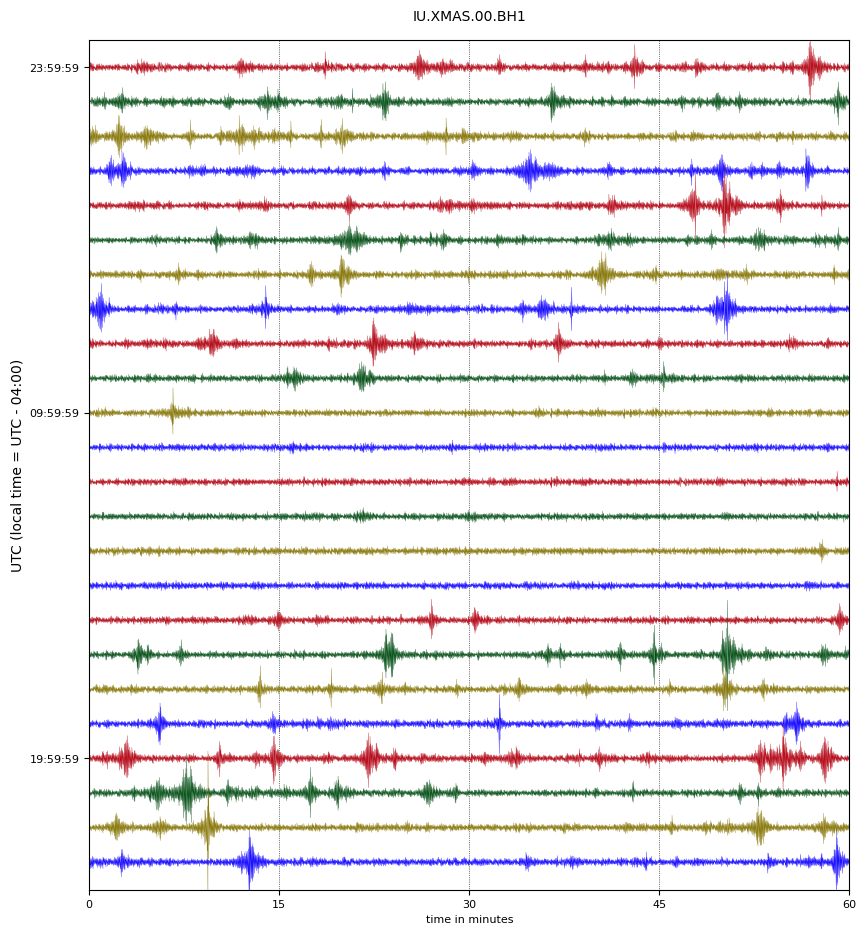

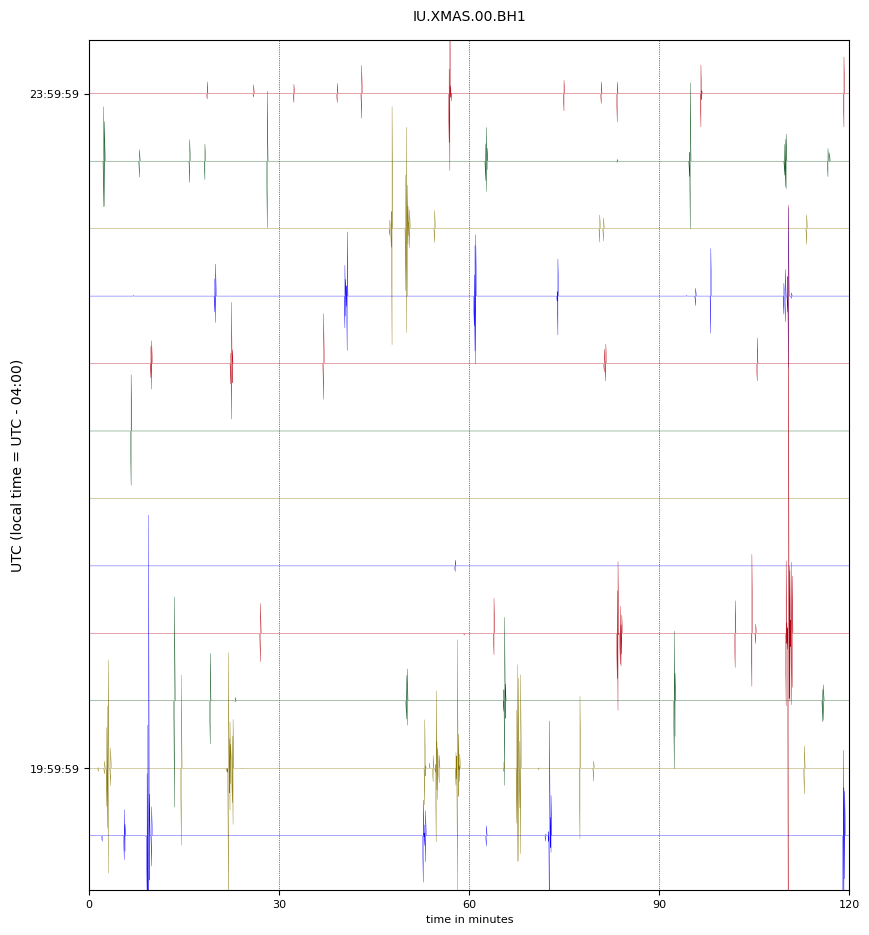

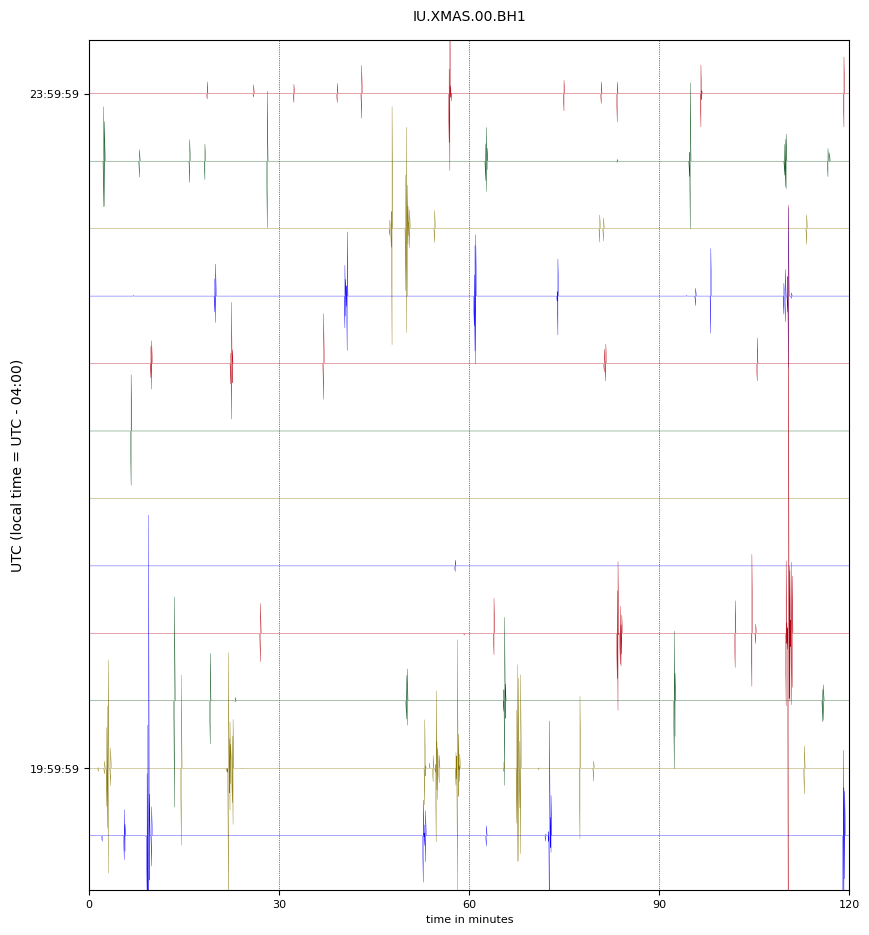

In [163]:
st.plot(type='dayplot',interval=60, size=(1000,1000), linewidth=0.25)
st_denoise.plot(type='dayplot',interval=120, size=(1000,1000), linewidth=0.25)

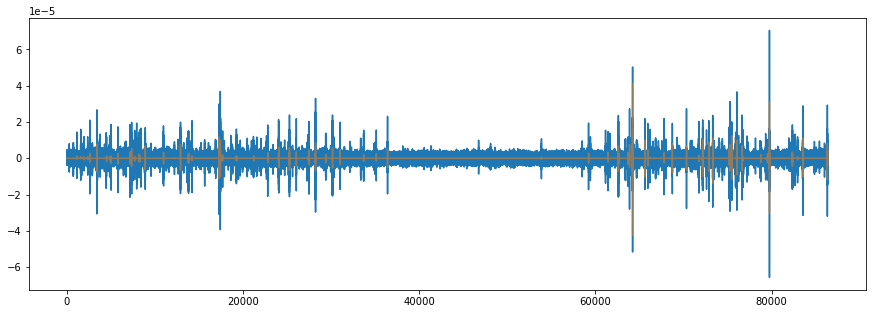

In [164]:
st_time = np.arange(st[0].stats.npts)*st[0].stats.delta
plt.figure(figsize=(15,5))
plt.plot(st_time, st[0].data)
plt.plot(st_time, st_denoise, alpha=0.5)


Compare FFT

In [151]:
st_spectrum = fft.fft(st[0].data)
st_time = np.arange(st[0].stats.npts)*st[0].stats.delta
freq = np.fft.fftfreq(len(st[0].data),st[0].stats.delta)

In [152]:
st_denoise_spectrum = fft.fft(st_denoise.data)
st_time = np.arange(st_denoise.stats.npts)*st_denoise.stats.delta
freq = np.fft.fftfreq(len(st_denoise.data),st_denoise.stats.delta)

In [153]:
plt.figure(figsize=(10,10))
plt.loglog(freq[freq>0], np.abs(st_spectrum[freq>0]))
plt.loglog(freq[freq>0], np.abs(st_denoise_spectrum[freq>0]), alpha=0.4)
plt.xlim(1,10)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3456001 but corresponding boolean dimension is 144001

<Figure size 720x720 with 0 Axes>

In [84]:
st_spectrum

array([  3.11142866e-07 -0.00000000e+00j,
         3.11142866e-07 +2.96518917e-13j,
         3.11142866e-07 +5.93036488e-13j, ...,
         3.11142866e-07 -8.89552713e-13j,
         3.11142866e-07 -5.93036488e-13j,   3.11142866e-07 -2.96518917e-13j])

In [77]:
st_spectrum.shape

(3456001,)

In [12]:
waveform_issq_threshold = issq_cwt(Twxo_threshold)

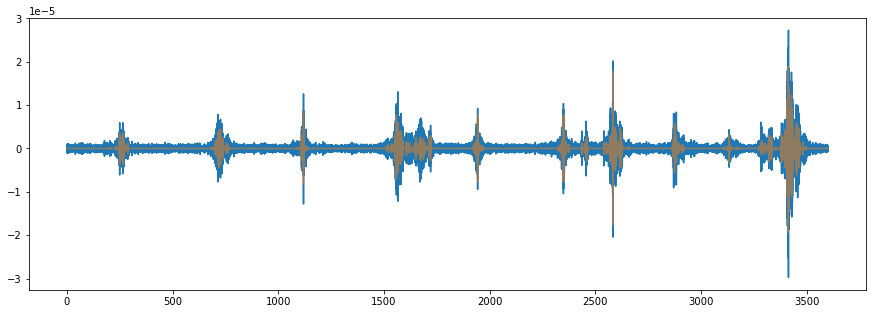

In [13]:
plt.figure(figsize=(15,5))
plt.plot(waveform_time, waveform_data)
plt.plot(waveform_time, waveform_issq_threshold, alpha=0.5)
#plt.xlim(140,210)
#plt.ylim(-2e-6,2e-6)


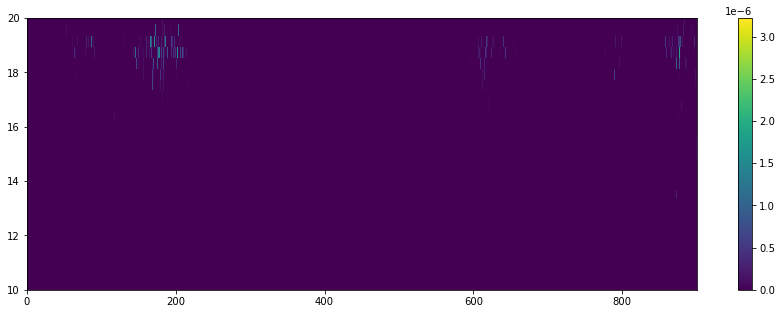

In [101]:
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, ssq_freqs, abs(Twxo_threshold),shading='auto')
plt.colorbar(sb)
plt.ylim(fs/4, fs/2)
plt.show()

In [104]:
np.where?

In [92]:
issq_cwt?

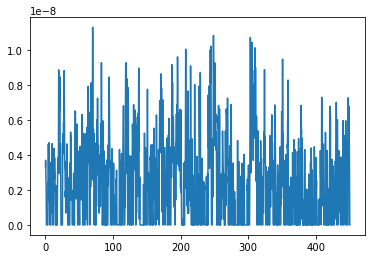

In [85]:
DF_time = np.sum(abs(Twxo),axis=0)
DF_time.shape
plt.plot(waveform_time, DF_time)

In [35]:
# hard thresholding
amp = np.amax(np.abs(Twxo))
Twxo_threshold = np.where(np.abs(Twxo) >= amp/5, Twxo, 0)

In [74]:
ssq_cwt?

/Users/Yin9xun/opt/anaconda3/envs/spyder-py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


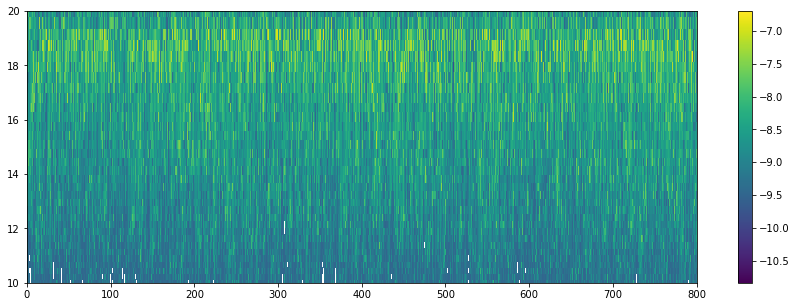

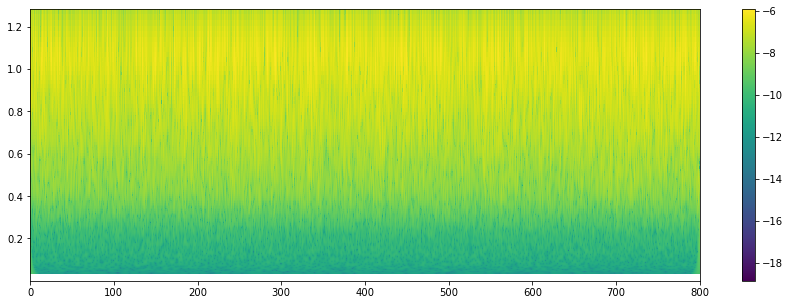

In [71]:
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, ssq_freqs, np.log10(abs(Twxo)),shading='auto')#shading='gouraud')
plt.colorbar(sb)
plt.ylim(fs/4, fs/2)
plt.show()
plt.figure(figsize=(15,5))
sb = plt.pcolormesh(waveform_time, 1/scale, np.log10(abs(Wxo)),shading='auto')#shading='gouraud')
plt.colorbar(sb)
plt.show()

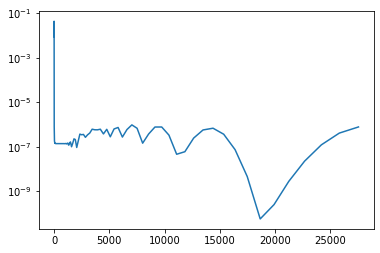

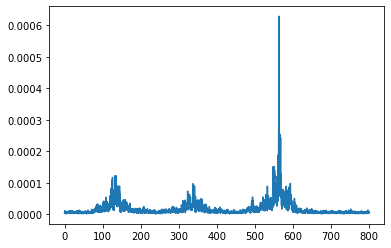

In [42]:
CF = np.sum(abs(Wxo), axis=1)
plt.semilogy(scale,CF)
plt.show()
DF = np.sum(abs(Wxo), axis=0)
plt.plot(waveform_time, DF)
plt.show()

In [35]:
plt.pcolormesh?

(0.0, 100.0)

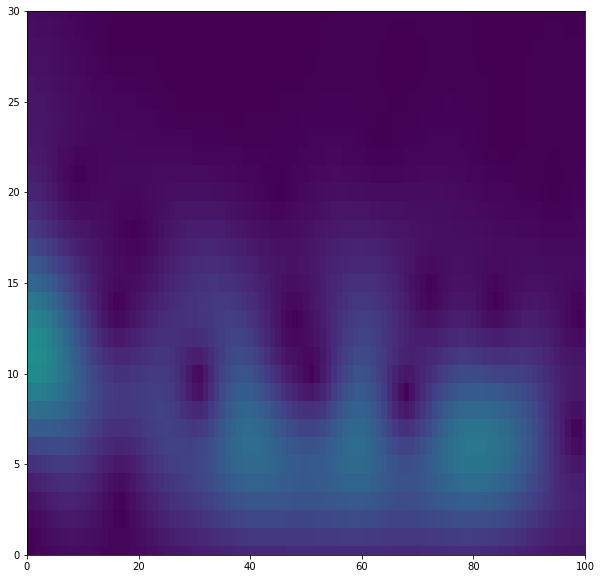

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(abs(Twxo), aspect='auto')
plt.ylim(0,30)
plt.xlim(0,100)

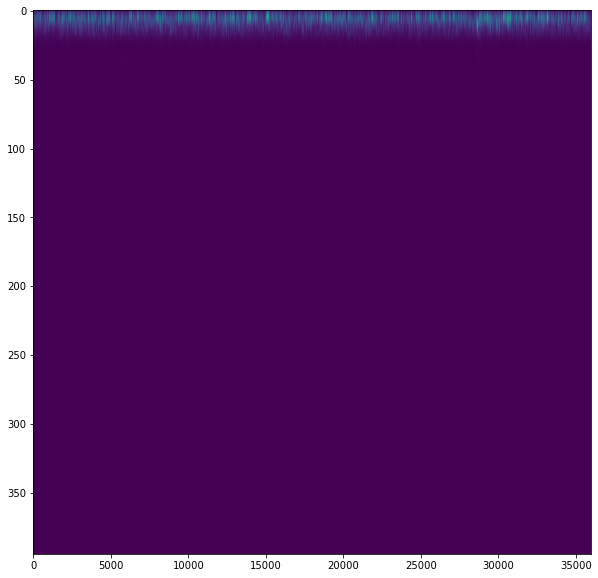

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(abs(Wxo), aspect='auto')

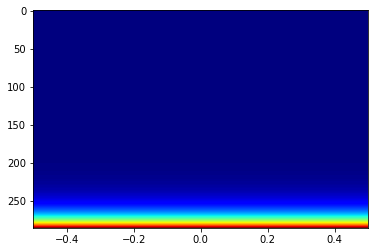

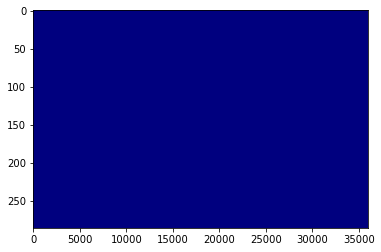

In [39]:
Twxo, Wxo, *_ = cwt(waveform_data)
viz(xo, Twxo, Wxo)

In [40]:
waveform_inverse = icwt(Twxo)

(0.0, 100.0)

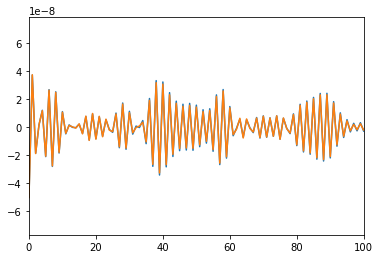

In [42]:
plt.plot(waveform_data)
plt.plot(waveform_inverse)
plt.xlim(0,100)

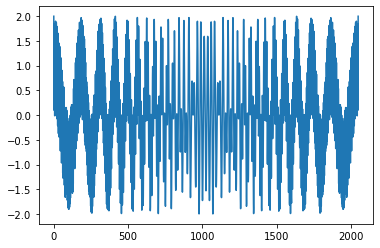

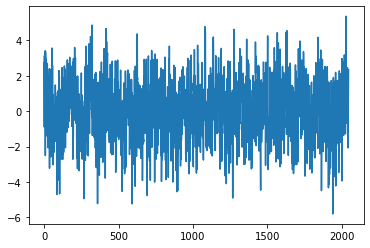

In [3]:
N = 2048
t = np.linspace(0, 10, N, endpoint=False)
xo = np.cos(2 * np.pi * 2 * (np.exp(t/2.2)-1))
xo += xo[::-1]
x = xo + np.sqrt(2) * np.random.randn(N)

plt.plot(xo); plt.show()
plt.plot(x); plt.show()

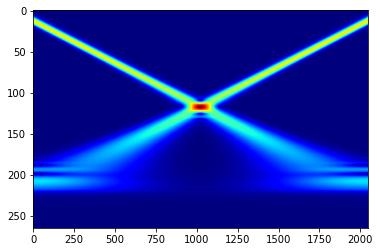

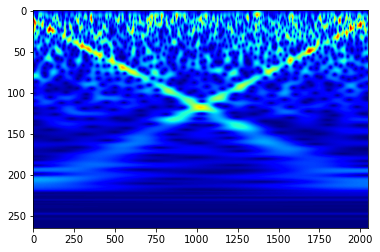

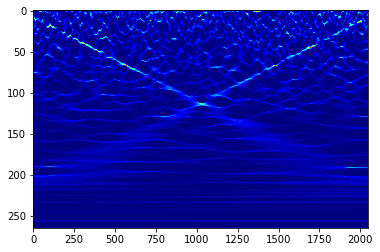

In [4]:
Twxo, Wxo, *_ = ssq_cwt(xo)
viz(xo, Twxo, Wxo)

Twx, Wx, *_ = ssq_cwt(x)
viz(x, Twx, Wx)

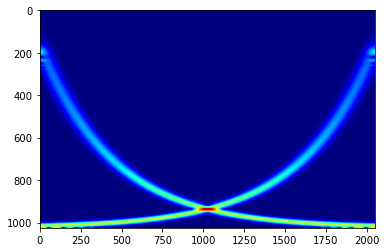

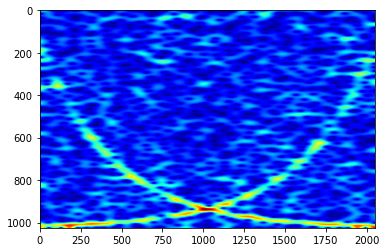

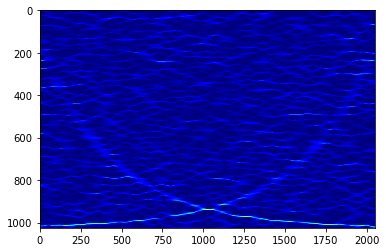

In [5]:
Tsxo, Sxo, *_ = ssq_stft(xo)
viz(xo, Tsxo, np.flipud(Sxo))

Tsx, Sx, *_ = ssq_stft(x)
viz(x, Tsx, np.flipud(Sx))

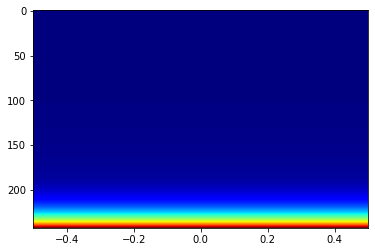

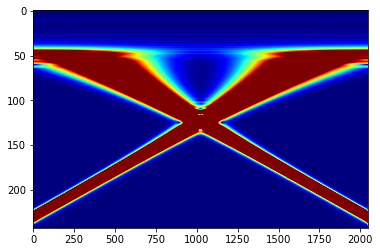

In [9]:
Twxo, Wxo, *_ = cwt(xo)
viz(xo, Twxo, Wxo)

In [10]:
icwt?

In [13]:
xo_inv = icwt(Twxo)

(500.0, 600.0)

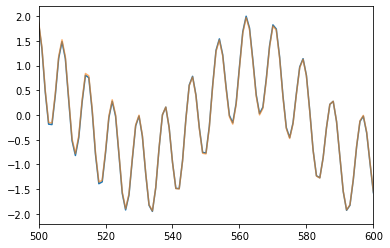

In [19]:
plt.plot(xo_inv)
plt.plot(xo,alpha=0.6)
plt.xlim(500, 600)

In [22]:
Wxo.shape

(243, 1)

In [23]:
Twxo.shape

(243, 2048)